In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from analysis.plotting import plot_average_events_wavelet
from analysis.spindles import spindles_detect_thalamus
from custom_models.adex_thalamus_old import (
    DEFAULT_ADEX_NODE_CONNECTIVITY,
    DEFAULT_ADEX_NODE_DELAYS,
    DEFAULT_PARAMS_EXC,
    DEFAULT_PARAMS_INH,
    DEFAULT_PARAMS_TCR,
    DEFAULT_PARAMS_TRN,
    DEFAULT_THALAMIC_CONNECTIVITY,
    AdExThalamusMiniNetwork,
)
from models.model_input import OrnsteinUhlenbeckProcess, ZeroInput
from neuro_signal import RatesSignal
from neuro_signal.routines import get_amplitude
from yasa import get_centered_indices

DPI = 75
CMAP = "plasma"
plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")

SW = {"low_freq": 0.1, "high_freq": 2.5}
SP = {"low_freq": 11.0, "high_freq": 16.0}

In [2]:
def simulate(
    conn=2.0,
    ou_exc=4.1,
    ou_inh=1.8,
    ou_sigma=0.0,
    tauA=1000.0,
    glk=0.018,
    a=0.0,
    b=15.0,
):
    # all times in ms
    duration = 30000.0
    t_spin_up = 5000.0
    sampling_dt = 1.0
    dt = 0.005

    model = AdExThalamusMiniNetwork(
        connectivity_matrix=np.array([[0.0, 0.0], [conn, 0.0]]),
        delay_matrix=np.array([[0.0, 13.0], [13.0, 0.0]]),
        thalamus_params=[
            {**DEFAULT_PARAMS_TCR, "g_LK": glk},
            {**DEFAULT_PARAMS_TRN, "g_LK": glk},
            DEFAULT_THALAMIC_CONNECTIVITY,
        ],
        adex_params=[
            {**DEFAULT_PARAMS_EXC, "tau_A": tauA, "a": a, "b": b},
            DEFAULT_PARAMS_INH,
            DEFAULT_ADEX_NODE_CONNECTIVITY,
            DEFAULT_ADEX_NODE_DELAYS,
        ],
    )
    adex_exc = OrnsteinUhlenbeckProcess(
        duration + t_spin_up,
        dt,
        mu=ou_exc,
        sigma=ou_sigma,
        tau=5.0,
    ).as_array()
    adex_inh = OrnsteinUhlenbeckProcess(
        duration + t_spin_up,
        dt,
        mu=ou_inh,
        sigma=ou_sigma,
        tau=5.0,
    ).as_array()
    thalamus_exc = ZeroInput(duration + t_spin_up, dt=dt).as_array()
    thalamus_inh = ZeroInput(duration + t_spin_up, dt=dt).as_array()
    results = model.run(
        duration=duration,
        sampling_dt=sampling_dt,
        dt=dt,
        noise_input=np.hstack([adex_exc, adex_inh, thalamus_exc, thalamus_inh]),
        time_spin_up=t_spin_up,
        backend="numba",
    )
    results_df = pd.DataFrame(
        {
            "ALN-EXC": (results["q_mean_EXC"].isel({"node": 0}) * 1000.0).values,
            "ALN-INH": (results["q_mean_INH"].isel({"node": 0}) * 1000.0).values,
            "I_adapt": (results["I_A_EXC"].isel({"node": 0})).values,
            "TCR": (results["q_mean_EXC"].isel({"node": 1}) * 1000.0).values,
        },
        index=results.time,
    )
    results_df.index.name = "time"
    return results_df

In [3]:
def plot_single(df, ax):
    (l1,) = ax.plot(df.index, df["ALN-INH"], color="C1", alpha=0.7)
    (l2,) = ax.plot(df.index, df["ALN-EXC"], color="C0")
    #     ax.set_ylim([-10, 80])
    sns.despine(trim=True, ax=ax)
    ax2 = ax.twinx()
    ax2.plot(df.index, df["TCR"], color="k", linewidth=2.5, alpha=0.5)
    ax2.set_ylim([-50, 1600.0])
    ax2.set_yticks([])
    sns.despine(trim=True, ax=ax2)
    return l1, l2


def get_indices_spindles(df, before=0.8, after=0.8):
    sf = sf = float(1.0 / (df.index[1] - df.index[0]))
    sp = spindles_detect_thalamus(xr.DataArray(df["TCR"])).summary()
    idx, _ = get_centered_indices(
        df["ALN-EXC"].values,
        (sp["Peak"] * sf).astype(int).to_numpy(),
        int(before * sf),
        int(after * sf),
    )
    return idx


def plot_wvlt(df, ax, before=1.0, after=1.0):
    idxs = get_indices_spindles(df, after=after, before=before)
    tcr_amp = get_amplitude(
        RatesSignal(xr.DataArray(df["TCR"])), filter_args=SP, pad=5.0
    )
    aln_sp_amp = get_amplitude(
        RatesSignal(xr.DataArray(df["ALN-EXC"])), filter_args=SP, pad=5.0
    )
    aln_sw_amp = get_amplitude(
        RatesSignal(xr.DataArray(df["ALN-EXC"])), filter_args=SW, pad=5.0
    )
    handler = plot_average_events_wavelet(
        xr.DataArray(df["ALN-EXC"]).squeeze(),
        events_idx=idxs,
        time_before=before,
        time_after=after,
        freqs_bounds=(0.5, 25.0),
        ax=ax,
        cmap=CMAP,
        additional_ts={
            "TCR spindle envelope": tcr_amp.data.values,
            "EXC spindle envelope": aln_sp_amp.data.values,
            "EXC slow wave envelope": aln_sw_amp.data.values,
        },
        additional_ts_colors=["yellow", "w", "lime"],
        title="Average ALN-EXC while spindle",
        rasterized=True,
        return_legend_handler=True,
    )
    ax.set_title("")
    ax.set_ylabel("")
    ax.set_xlabel("")
    plt.gca().get_legend().remove()
    return handler

/Users/nikola/work-brain/sleep_rhythms/code/analysis/plotting.py:656: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  rasterized=rasterized,
/Users/nikola/work-brain/sleep_rhythms/code/analysis/plotting.py:656: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  rasterized=rasterized,
/Users/nikola/work-brain/sleep_rhythms/code/analysis/plotting.py:656: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  

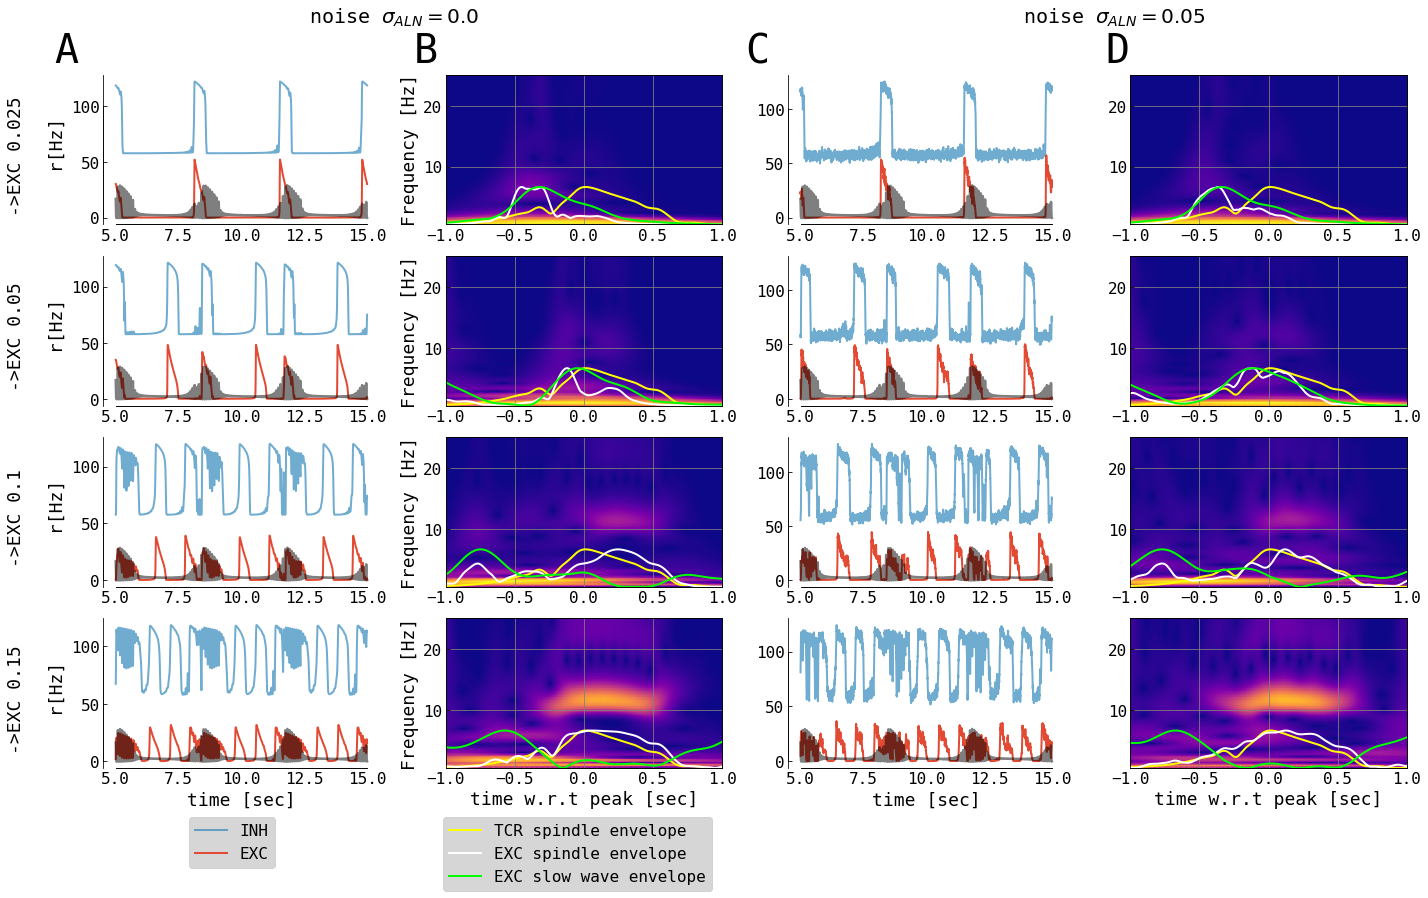

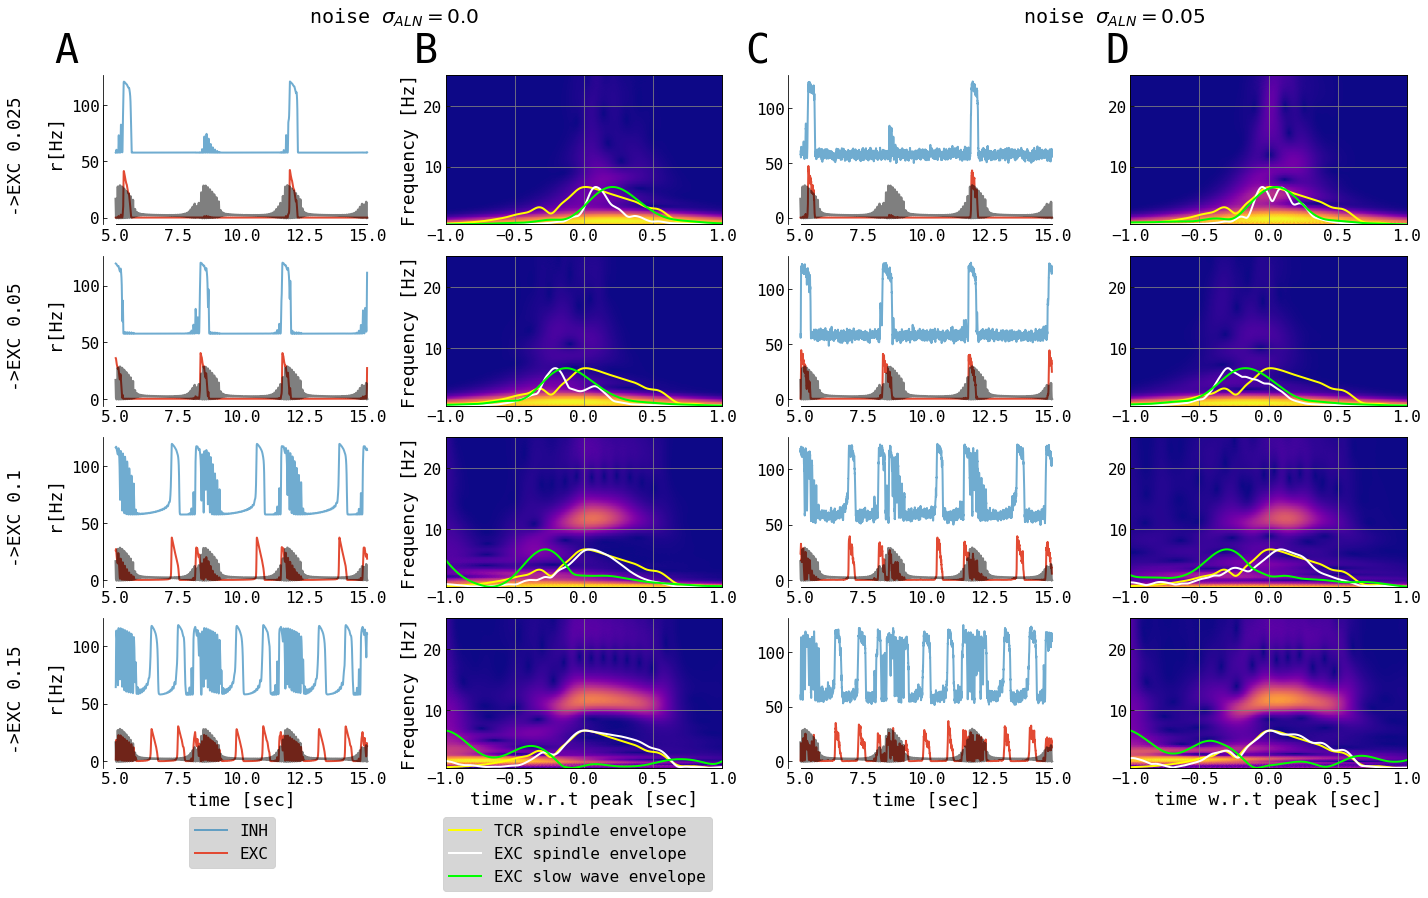

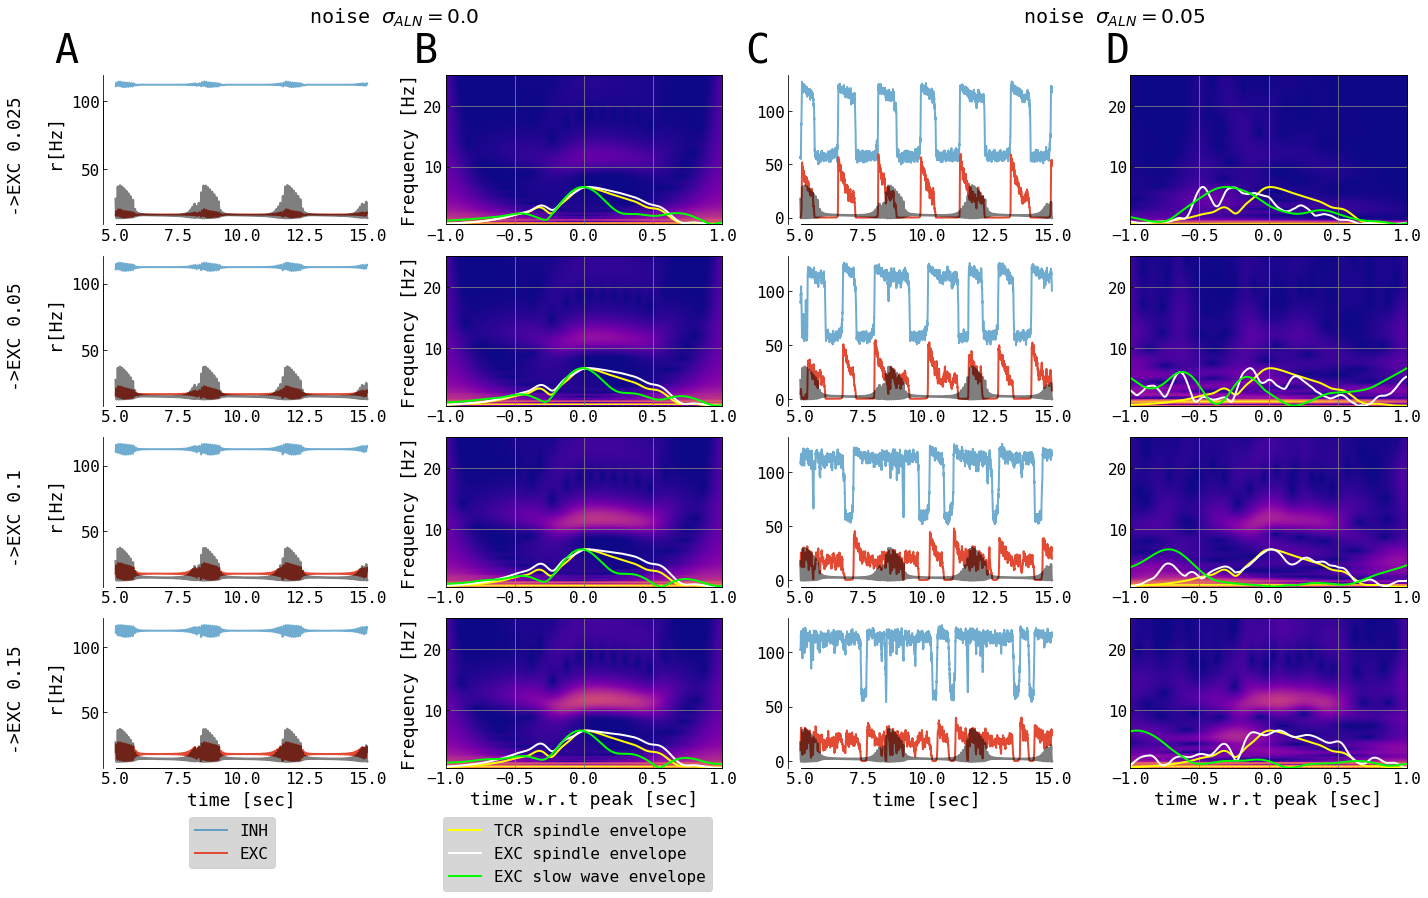

In [10]:
conns = [0.025, 0.05, 0.1, 0.15]
noises = [0.0, 0.05]

params = [(2.8, 3.5, "inside_lc"), (2.5, 3.5, "left_border"), (3.3, 3.5, "right_border")]

for exc_inp, inh_inp, plot_name in params:
    fig, axs = plt.subplots(nrows=len(conns), ncols=len(noises) * 2, figsize=(20, 11.5))
    for i, conn in enumerate(conns):
        for j, noise in enumerate(noises):
            ax = axs[i, j * 2]
            df = simulate(
                conn=conn,
                ou_exc=exc_inp,
                ou_inh=inh_inp,
                ou_sigma=noise,
                tauA=1000.0,
                glk=0.032,
                a=0.0,
                b=15.0,
            )
            l1, l2 = plot_single(df.loc[5:15], ax=ax)
            if i == 3:
                ax.set_xlabel("time [sec]")
            if j == 0:
                ax.set_ylabel(f"->EXC {conn} \n\n r[Hz]")
            ax = axs[i, j * 2 + 1]
            lines = plot_wvlt(df, ax=ax)
            if j == 0:
                ax.set_ylabel("Frequency [Hz]")
            if i == 3:
                ax.set_xlabel("time w.r.t peak [sec]")
    for j, noise in enumerate(noises):
        ax_tit = fig.add_subplot(1, 2, j + 1, frameon=False)
        ax_tit.set_title(f"noise $\sigma_{{ALN}}={noise}$ \n\n")
        ax_tit.set_xticks([])
        ax_tit.set_yticks([])

    plt.tight_layout()
    fig.legend(
        (l1, l2),
        ("INH", "EXC"),
        loc="upper center",
        bbox_to_anchor=(0.165, 0.015),
        bbox_transform=fig.transFigure,
    )
    fig.legend(
        lines,
        ("TCR spindle envelope", "EXC spindle envelope", "EXC slow wave envelope"),
        loc="upper center",
        bbox_to_anchor=(0.405, 0.015),
        bbox_transform=fig.transFigure,
    )
    for subplt, pos in zip(["A", "B", "C", "D"], [0.05, 0.3, 0.53, 0.78]):
        plt.text(
            pos,
            0.93,
            subplt,
            ha="center",
            va="center",
            transform=fig.transFigure,
            fontsize=40,
        )
    # to PDF due transparency
    plt.savefig(
        f"../figs/aln_rec_spindle_{plot_name}.pdf", transparent=True, bbox_inches="tight"
    )